
# Affinity Propagation(AP)

In [1]:

# 필수 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# 재현성을 위해 난수 고정
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 1) 데이터 생성

- 클러스터 4개짜리 2D 데이터셋을 생성
- 이후 AP가 자동으로 **클러스터 개수를 학습**하도록 `preference`를 기본값(유사도 중앙값)으로 둠둠


데이터 모양: (600, 2), y_true 고유 라벨 수: 4


C:\Users\User\AppData\Local\Temp\ipykernel_536\3947497009.py:14: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_536\3947497009.py:14: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_536\3947497009.py:14: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_536\3947497009.py:14: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_536\3947497009.py:14: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_536\3947497009.py:14: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaV

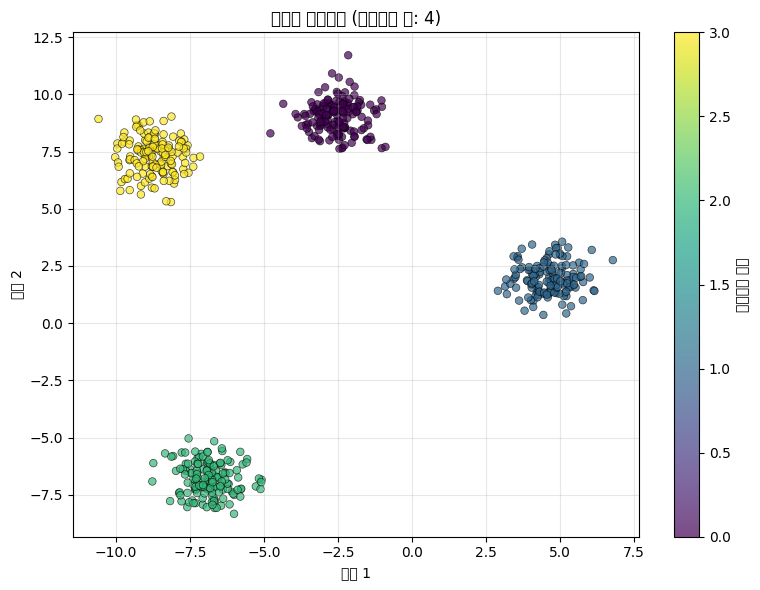

In [3]:
# 데이터 생성
X, y_true = make_blobs(n_samples=600, centers=4, cluster_std=0.70, random_state=RANDOM_STATE)

print(f"데이터 모양: {X.shape}, y_true 고유 라벨 수: {len(np.unique(y_true))}")

# 데이터 시각화
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='클러스터 라벨')
plt.xlabel('특성 1')
plt.ylabel('특성 2')
plt.title(f'생성된 데이터셋 (클러스터 수: {len(np.unique(y_true))})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 2) 유사도 행렬 정의

AP는 입력으로 **유사도행렬** $(S)$ 을 사용, 표준적으로 **음의 제곱거리**를 사용

$$ s(i,k) = -\lVert x_i - x_k \rVert^2 $$

- 대각선 값 $( s(k,k) )$ 은 **preference(선호도)** 로 쓰이며 기본적으로 `S`의 **중앙값**을 사용하면 안정적
    * `preference` ↑ (덜 음수/더 큰 값) → “나도 대표할래” 점들이 늘어 **군집 수 ↑**
    * `preference` ↓ (더 음수/작은 값) → 대표로 나서는 점이 줄어 **군집 수 ↓**


 AP에서 쓰는 유사도 행렬 (S)

코드에서는 **음의 제곱거리**를 유사도로 쓰므로
$$

S = -D = -\big(d\mathbf{1}^\top + \mathbf{1}d^\top - 2G\big) = 2G - d\mathbf{1}^\top - \mathbf{1}d^\top


$$

**원소 단위**로는
$$

S_{ik} = -\lVert x_i - x_k\rVert_2^2 = -d_i - d_k + 2 G_{ik}

$$

- 여기서 사용하는 행렬인 그람(Gram) 행렬은 선형대수학 및 기하학에서 벡터 집합의 내적(스칼라 곱) 결과로 구성된 행렬
$$
G = \begin{pmatrix} \langle \mathbf{x}_1, \mathbf{x}_1 \rangle & \ldots & \langle \mathbf{x}_1, \mathbf{x}_n \rangle \\ \vdots & \ddots & \vdots \\ \langle \mathbf{x}_n, \mathbf{x}_1 \rangle & \ldots & \langle \mathbf{x}_n, \mathbf{x}_n \rangle \end{pmatrix}
$$

In [ ]:

def pairwise_neg_sq_euclidean(X: np.ndarray) -> np.ndarray:
    """
    s(i,k) = -||x_i - x_k||^2  (음의 제곱거리)
    X: (N, D)
    return S: (N, N)
    """
    sq = np.sum(X**2, axis=1, keepdims=True)  # (N,1)
    S = sq + sq.T - 2 * (X @ X.T) # (X @ X.T) = G
    return -S

# 유사도 행렬 계산
S = pairwise_neg_sq_euclidean(X)
print("S shape:", S.shape, " | 예: S[0,1]=", np.round(S[0,1], 3))

# 기본 preference는 중앙값으로 (실제 AP 함수에서 대각선에 채워 넣음)
pref_default = np.median(S)
print("기본 preference (median of S):", round(float(pref_default), 3))

S shape: (600, 600)  | 예: S[0,1]= -1.772
기본 preference (median of S): -143.598



## 3) Affinity Propagation(AP) 구현

### 3-1) 핵심 메시지 갱신 식
- 유사도 $S∈R^{N×N}$가 있을 때 반복(iteration)마다 

- $R ←$ 책임도 갱신
  - **책임도(Responsibility)** $( r(i,k) )$:  
    $$r(i,k) \leftarrow s(i,k) - \max_{k' \neq k} \{ a(i,k') + s(i,k') \}$$
    - $i$가 $k$를 대표로 고르는 게 다른 후보 $k′$보다 얼마나 더 좋은가?”
    - → 같은 행(샘플 $i$) 안에서 경쟁 비교

- $A ←$ 가용도 갱신:
  - **가용도(Availability)** $( a(i,k) )$:  
    - $k$가 $i$를 대표로 받아줄 ‘여유/타당성’이 있는가?(다른 점들이 $k$를 얼마나 밀어주고 있는가)
    - → 같은 열(대표 후보 k)에서 지지 합산
    $$
    a(i,k) \leftarrow 
    \begin{cases}
    \sum_{i' \neq k} \max(0, r(i',k)) & (i=k) \\
    \min\big(0,\ r(k,k) + \sum_{i' \notin \{i,k\}} \max(0, r(i',k))\big) & (i\neq k)
    \end{cases}
    $$

- 두 메시지를 반복 교환하며 대각선 $𝑎(𝑘,𝑘)+𝑟(𝑘,𝑘)$ 이 양수인 $k$ 들이 대표점(exemplar) 이 됩

### 3-2) 평활화(damping)
- 새로 계산한 $\hat R,\hat A$ 를 이전 값과 섞어 진동을 줄임
$$
R\leftarrow (1-\lambda)\hat R + \lambda R,\quad
A\leftarrow (1-\lambda)\hat A + \lambda A,\quad (\lambda\in[0,1))
$$
- 진동 방지를 위해 $ M^{(t)} \leftarrow (1-\lambda)\,\hat M^{(t)} + \lambda\,M^{(t-1)} $ 로 갱신(보통 0.7~0.95)

### 3-3) 수렴 판단
- $( a(k,k) + r(k,k) > 0 )$ 인 $k$들을 **exemplar(대표점)** 으로 보고, 최근 `conv_iter` 동안 동일하면 수렴으로 간주


In [5]:

def affinity_propagation(
    S: np.ndarray,
    damping: float = 0.9,
    max_iter: int = 300,
    conv_iter: int = 15,
    preference: float | None = None,
    random_state: int | None = 0
):
    """
    순수 NumPy AP 구현.
    - S: (N,N) 유사도 행렬. 대각선은 preference로 사용됨.
    반환:
      exemplars (list[int]), labels (np.ndarray shape (N,)), A, R
    """
    rng = np.random.default_rng(random_state)
    N = S.shape[0]
    S = S.copy()

    # 선호도 세팅
    if preference is None:
        pref = np.median(S)
    else:
        pref = float(preference)
    np.fill_diagonal(S, pref)

    # 메시지 초기화
    A = np.zeros((N, N), dtype=np.float64)  # availability
    R = np.zeros((N, N), dtype=np.float64)  # responsibility

    # 수렴 추적용 버퍼
    exemplars_history = np.zeros((conv_iter, N), dtype=bool)
    history_idx = 0

    for it in range(max_iter):
        # ---------- 책임도 R 업데이트 ----------
        AS = A + S
        max1 = AS.max(axis=1)              # (N,)
        argmax = AS.argmax(axis=1)         # (N,)

        AS2 = AS.copy()
        AS2[np.arange(N), argmax] = -np.inf
        max2 = AS2.max(axis=1)             # (N,)

        R_new = S - max1[:, None]
        R_new[np.arange(N), argmax] = S[np.arange(N), argmax] - max2

        # 댐핑
        R = damping * R + (1 - damping) * R_new

        # ---------- 가용도 A 업데이트 ----------
        Rp = np.maximum(R, 0.0)
        Rp[np.arange(N), np.arange(N)] = R[np.arange(N), np.arange(N)]

        col_sum = np.sum(Rp, axis=0, keepdims=True)  # (1,N)

        A_new = col_sum - Rp
        A_new = np.minimum(0.0, A_new)

        A_new[np.arange(N), np.arange(N)] = np.sum(np.maximum(0.0, R), axis=0) - np.maximum(0.0, R[np.arange(N), np.arange(N)])

        # 댐핑
        A = damping * A + (1 - damping) * A_new

        # ---------- 수렴 검사 ----------
        E = (np.diag(A) + np.diag(R)) > 0  # exemplar 여부 (N,)
        exemplars_history[history_idx % conv_iter] = E
        history_idx += 1

        if it >= conv_iter:
            # 최근 conv_iter 번의 E가 모두 동일하면 수렴
            if np.all(exemplars_history == E, axis=0).all():
                break

    exemplars = np.where((np.diag(A) + np.diag(R)) > 0)[0]
    if len(exemplars) == 0:
        exemplars = np.array([np.argmax(np.diag(A + R))])

    AR = A + S
    labels = exemplars[np.argmax(AR[:, exemplars], axis=1)]

    return exemplars.tolist(), labels, A, R



## 4) AP 실행

- 기본 `preference` = `median(S)`  
- `damping` = 0.9, `max_iter` = 300, `conv_iter` = 15


In [6]:

exemplars, labels, A, R = affinity_propagation(
    S,
    damping=0.9,
    max_iter=300,
    conv_iter=15,
    preference=None,
    random_state=RANDOM_STATE
)

uniq_ex = np.unique(exemplars)
uniq_labels = np.unique(labels)
print(f"[AP 결과] exemplar 수: {len(uniq_ex)} | 라벨(클러스터) 수: {len(uniq_labels)}")
print("exemplar 인덱스(일부):", exemplars[:10])

[AP 결과] exemplar 수: 1 | 라벨(클러스터) 수: 1
exemplar 인덱스(일부): [595]



## 5) 시각화

- 각 포인트는 자신이 속한 **exemplar(라벨)** 기준으로 색칠합니다.  
- **별표(★)** 로 exemplar를 표시합니다.


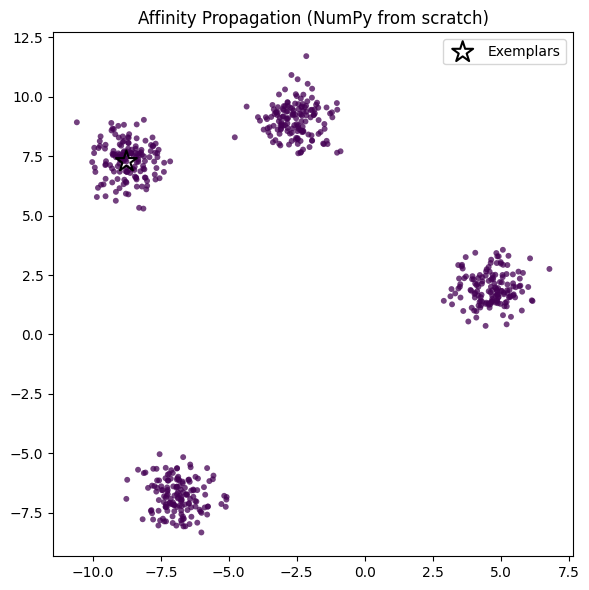

In [7]:

plt.figure(figsize=(6,6))

uniq_lbls = np.unique(labels)
ex2cid = {ex:i for i, ex in enumerate(uniq_lbls)}
color_ids = np.array([ex2cid[l] for l in labels])

plt.scatter(X[:,0], X[:,1], c=color_ids, s=18, alpha=0.75, edgecolors='none')
plt.scatter(X[exemplars,0], X[exemplars,1], marker='*', s=250, linewidths=1.5,
            facecolors='none', edgecolors='k', label='Exemplars')

plt.title("Affinity Propagation (NumPy from scratch)")
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## 6) 하이퍼파라미터 탐색 — `preference` & `damping`

- **`preference`** 를 키우면 **클러스터 수가 증가**하는 경향, 낮추면 감소.  
- **`damping`** 은 진동 방지(0.7~0.95 권장).


In [8]:

factors = [0.8, 1.0, 1.2, 1.5]
results = []

for fac in factors:
    pref = np.median(S) * fac
    ex, lab, *_ = affinity_propagation(S, damping=0.9, max_iter=300, conv_iter=15, preference=pref, random_state=RANDOM_STATE)
    results.append((fac, len(np.unique(lab))))

print("preference × median vs. #clusters:")
for fac, k in results:
    print(f"  {fac:>4}×  ->  {k} clusters")

preference × median vs. #clusters:
   0.8×  ->  1 clusters
   1.0×  ->  1 clusters
   1.2×  ->  1 clusters
   1.5×  ->  1 clusters



## 7) (선택) `sklearn` 구현과 결과 비교

- `sklearn.cluster.AffinityPropagation` 을 동일한 유사도/설정으로 실행해 클러스터 수를 비교합니다.
- `affinity='precomputed'` 를 사용할 때는 **대각선에 preference** 가 들어가 있어야 합니다.


In [9]:

try:
    from sklearn.cluster import AffinityPropagation as SKAP

    S_cmp = pairwise_neg_sq_euclidean(X)
    pref = np.median(S_cmp)
    np.fill_diagonal(S_cmp, pref)

    ap_skl = SKAP(random_state=RANDOM_STATE, damping=0.9, max_iter=300, convergence_iter=15, affinity='precomputed')
    ap_skl.fit(S_cmp)
    labels_skl = ap_skl.labels_
    print(f"[sklearn AP] 클러스터 수: {len(np.unique(labels_skl))}")
except Exception as e:
    print("sklearn 비교 중 에러:", e)

[sklearn AP] 클러스터 수: 4



## 8) 진단/디버깅 팁

- 마지막 반복의 **대표성 점수** \( \operatorname{diag}(A) + \operatorname{diag}(R) \) 을 보면 어떤 포인트가 exemplar 로 선택되는지 감을 잡을 수 있습니다.


In [10]:

diag_scores = np.diag(A) + np.diag(R)
top = np.sort(diag_scores)[-10:]
print("상위 10개 (a+r) 대각 점수:", np.round(top, 3))

상위 10개 (a+r) 대각 점수: [-13.549 -13.49  -13.475 -13.112 -13.111 -12.933 -12.556 -12.543 -12.23
 -11.929]
